In [1]:
import time,sys
import pandas as pd
import numpy as np
import itertools 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
import umap

In [2]:
def ProgressBar(total, progress):
    """ ProgressBar - Displays or updates a console progress bar.
    ######################     EXAMPLE     ######################
    
    runs = 300
    for run_num in range(runs):
        time.sleep(.1)
        ProgressBar(runs, run_num + 1)
        
    #############################################################
    Original source: https://stackoverflow.com/a/15860757/1391441
    """
    barLength, status = 20, ""
    progress = float(progress) / float(total)
    if progress >= 1.:
        progress, status = 1, "\r\n"
    block = int(round(barLength * progress))
    text = "\r[{}] {:.0f}% {}".format(
        "#" * block + "-" * (barLength - block), round(progress * 100, 0),
        status)
    sys.stdout.write(text)
    sys.stdout.flush()

In [3]:
def read_data(train_in_csv, train_out_csv, test_int_csv, test_out_csv):
    """Reads data from CSV files and returns it as numpy arrays.
    """
    train_in = pd.read_csv("train_in.csv")
    train_out = pd.read_csv("train_out.csv")
    train_in = np.array(train_in)
    train_out = np.array(train_out)
    train_out = np.squeeze(train_out)

    test_in = pd.read_csv("test_in.csv")
    test_out = pd.read_csv("test_out.csv")
    test_in = np.array(test_in)
    test_out = np.array(test_out)
    test_out = np.squeeze(test_out, axis=1)
    
    return train_in, train_out, test_in, test_out

In [4]:
def get_points(train_in, train_out):
    """Method do represent digits 0-9 as a point in 256-dimensional space.
    
    This method considers 16x16 pixel images as points in 256 dimensional space,
    where each dimension is the brightness of a specific pixel. The method then 
    averages all point of a given digit to obtain an average point for each digit
    (0-9). It then computes the distances in these space between all average points.
    
    Arguments:
        train_in (array): An array of 16x16 images, represented by pixel brightness
        train_out (array): An array of labels indicating which digit (0-9) is represented
                           by the same indexed data point in train_in
    
    Returns:
        means (dict): A dictionary with points in 256-dimensional
                      space representing all digits 0-9
    """
    clouds = dict()

    for x in range(10):
        clouds[x] = train_in[np.where(train_out == x)[0],:]


    means = dict()
    for x in range(10):
        means[x] =  np.mean(clouds[x], axis=0)

    return means

def get_distances(means):
    """Method to get a distance matrix from a given set of 10 points.
    
    Arguments:
        means (dict): The set of points to obtain a distance matrix from
        
    Returns:
        distances (array): A 10x10 array with all distances between each point in means
    """
    distances = []
    for i in range(10):
        for j in range(10):
            distances.append(np.linalg.norm(means[i]-means[j]))
            
    distances = np.array(distances)
    distances = np.reshape(distances,(10,10))
    
    return distances

In [5]:
def plot_pca(train_in, train_out): 
    """Plots pixel brightness data using the PCA dimensionality reduction algorithm.
    
    Arguments:
        train_in (array): An array of 16x16 images, represented by pixel brightness
        train_out (array): An array of labels indicating which digit (0-9) is represented
                           by the same indexed data point in train_in
    """
    pca = PCA(n_components=2)
    PCs = pca.fit_transform(train_in)

    plt.figure(figsize=(10,10)) 

    for i in range(10):
        ind = train_out == i
        plt.scatter(PCs[ind, 0], PCs[ind, 1], label=i, s=25, alpha=1)

    plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left',fontsize=20)
    plt.title("PCA")
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    
def plot_umap(train_in, train_out):
    """Plots pixel brightness data using the UMAP dimensionality reduction algorithm.
    
    Arguments:
        train_in (array): An array of 16x16 images, represented by pixel brightness
        train_out (array): An array of labels indicating which digit (0-9) is represented
                           by the same indexed data point in train_in
    """
    umap = umap.UMAP()
    X_u = umap.fit_transform(train_in)

    plt.figure(figsize=(10,10))

    for i in range(10):
        ind = train_out == i
        plt.scatter(X_u[ind, 0], X_u[ind, 1], label=i, s=25, alpha=1)
        
    plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left', fontsize=20)
    plt.title("UMAP")
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    
def plot_tsne(train_in, train_out):
    """Plots pixel brightness data using the t-SNE dimensionality reduction algorithm.
    
    Arguments:
        train_in (array): An array of 16x16 images, represented by pixel brightness
        train_out (array): An array of labels indicating which digit (0-9) is represented
                           by the same indexed data point in train_in
    """
    t_sne = TSNE(n_components=2)
    X_tsne = t_sne.fit_transform(train_in)

    plt.figure(figsize=(10,10))

    for i in range(10):
        ind = train_out == i
        plt.scatter(X_tsne[ind, 0], X_tsne[ind, 1], label=i, s=25, alpha=1)
        
    plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left', fontsize=20)
    plt.title("t-SNE")
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")

In [6]:
def identify(_in, _out, means):
    """Given a set of points, identify each point by its closest neighbor.
    
    We have a dictionary of points representing each digit 0-9. Then, given
    a set of pixel data, we identify each data point as being the digit to
    which' mean it is closest. We compare this to the actual digit (label).
    
    Arguments:
        _in (array): An array of 16x16 images, represented by pixel brightness
        _out (array): An array of labels indicating which digit (0-9) is represented
                           by the same indexed data point in _in
    
    Returns:
        classes (array): Array of predicted digit values
    """
    classes = []
    for i in _in:
        distances = []
        for j in range(10):
            mean = means[j]
            dis = np.linalg.norm(mean-i)
            distances.append(dis)
        dis_min = np.amin(distances)
        _class = float(np.where(distances==dis_min)[0])
        classes.append(_class)

    classes = np.array(classes)
    
    return classes

In [7]:
def knn_predict(train_in, train_out, _in, n_neighbors):
    """Trains KNN identification using sk-learn module.
    
    Arguments:
        train_in (array): An array of 16x16 images, represented by pixel brightness
        train_out (array): An array of labels indicating which digit (0-9) is represented
                           by the same indexed data point in train_in
        _in (array): An array of 16x16 images, represented by pixel brightness
        n_neighbors (int): The amount (k) of neighbors used in the KNN classification
        
    Returns:
        knn_out (array): A prediction obtained by KNN classification
    """
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(train_in, train_out)
    knn_out = knn.predict(_in)
    
    return knn_out

def accuracy(prediction, labels):
    """Gives the accuracy of a given prediction.
    
    Arguments:
        prediction (array): Array of predicted digit values
        labels (array): Array of actual digit values
    Returns:
        succes_rate (float): A number between 0-1 representing the fraction of digits
                              that were identified correctly
    """
    diff = prediction - labels
    success_rate = len(np.where(diff == 0)[0])/len(labels)

    return success_rate

In [8]:
def task1(train_in, train_out, test_in, test_out):
    """Runs everything from the first task
    """
    points = get_points(train_in, train_out)
    distance_matrix = get_distances(points)
    
    train_predictions_points = identify(train_in, train_out, points)
    test_predictions_points = identify(test_in, test_out, points)
    train_predictions_knn = knn_predict(train_in, train_out, train_in, 12)
    test_predictions_knn = knn_predict(train_in, train_out, test_in, 12)
    
    conf_m_knn = confusion_matrix(test_out, test_predictions_knn)
    conf_m_knn_train = confusion_matrix(train_out, train_predictions_knn)

    conf_m_simp = confusion_matrix(test_out, test_predictions_points)
    conf_m_simp_train = confusion_matrix(train_out, train_predictions_points)
    
    plot_pca(train_in, train_out)
    plot_tsne(train_in, train_out)
    
    print("The distance between each point in 256-dimensional space:")
    print(distance_matrix)
    
    print("The succes rate using points clouds;\n on the training set:")
    print(accuracy(train_predictions_points,train_out))
    
    print(";on the test set:")
    print(accuracy(test_predictions_points,test_out))
    
    print("The succes rate using KNN classification;\n on the training set:")
    print(accuracy(train_predictions_knn,train_out))
    
    print("; on the test set:")
    print(accuracy(test_predictions_knn,test_out))
    
    print("Confusion matrix of point cloud method;\n on the training set:")
    print(conf_m_simp_train)
    
    print("; on the test set:")
    print(conf_m_simp)
    
    print("Confusion matrix of KNN classification;\n on the training set:")
    print(conf_m_knn_train)
    
    print("; on the test set:")
    print(conf_m_knn)

In [9]:
class Digit_perceptron:
    """The perceptron class is a module that contains all functions needed to define 
    a perceptron network capable of training its weights on a labeled set of training data and
    of giving predictions for digits given a set of unlabeled testing data.
    """
    def __init__(self, digit_matrix, weight=np.random.uniform(size=(256, 10)), bias=np.random.uniform(size=(10)), learning_rate=0.01, n_iters=100):
        """Constructor of the Digit Perceptron class.
        
        Arguments:
            digit_matrix (array): A matrix containing the digits to identify
            weight (array): An array of initial weights
            bias (array): An array of inital biases
            learning_rate (float): The learning rate defines the speed by which the weights
                                   and biases are updated
            n_iters (int): The amount of times the network cycles through the entire data set
        """
        self.lr = learning_rate
        self.n_iter = n_iters
        self.activation = self._none
        
        self.weights = weight
        self.bias = bias
        self.digit = digit_matrix
        
    def fit(self, x, y):
        """A function to update the networks weights and biases to a given set of data.
        
        Iterates through the data n_iter times, updating the weights using the update
        rule at every step.
        
        Arguments:
            x (array): An array of 16x16 pixel images, represented as numbers
            y (array): The digit label (0-9) of each image in x
        """
        y_m = np.repeat([y], [10], axis=0)
        y_ = np.ones(shape=y_m.shape)*(y_m==self.digit)
        
        for _ in range(self.n_iter):
            for i, x_i in enumerate(x):
                prediction = self.predict(x_i)
                update = self.lr*(y_[:,i]-self._u_step(prediction))

                self.weights += update * np.transpose(np.repeat(x_i[None,...], [10], axis=0))
                self.bias += update
                
    def predict(self, x):
        """Predicts the label(s) of a given data set.
        
        Arguments:
             x (array): An array of 16x16 pixel images, represented as numbers
             
        Returns: 
            y_predicted (array): The predicted digit label(s) for x
        """
        linear_output = np.dot(x, self.weights)+self.bias
        y_predicted = self.activation(linear_output)
        return y_predicted
    
    
    def _val_func(self, x):
        """The ReLU activation function; y=max(0,x)
        """
        return np.where(x>=0,x,0)
    
    def _u_step(self, x):
        """The unit step function
        """
        return np.where(x>0,1,0)
    
    def _none(self, x):
        return x

In [10]:
def task2(train_in,train_out,test_in,test_out):
    """Runs everything from the second task
    """
    d_x = np.arange(0,1706,1)
    d_y = np.arange(0,10,1)
    digit_mesh = np.meshgrid(d_x, d_y)[1]
    
    p = Digit_perceptron(digit_matrix=digit_mesh)
    p.fit(train_in, train_out)
    predictions = p.predict(test_in)
    predictions = np.argmax(np.squeeze(predictions), axis=1)
    
    succes_rate_perceptron = accuracy(predictions, test_out)
    
    print("The prediction accuracy of the perceptron network is:")
    print(succes_rate_perceptron)

In [11]:
def sigmoid(x):
    """The sigmoid activation function.
    """
    return 1 / (1 + np.exp(-x))
    
def delsigmoid(x):
    """The first derivative of the sigmoid function wrt x.
    """
    return np.exp(x) / (1 + np.exp(x))**2

def deltanh(x):
    """The first derivative of the tanh function wrt x.
    """
    return 1-np.tanh(x)**2

def relu(x):
    """The ReLU activation function.
    """
    return np.where(x>=0, x, 0)

def delrelu(x):
    """The first derivative of the ReLU function wrt x.
    """
    return np.where(x>=0, 1, 0)

def activ(which, x):
    """Sets the desired activation function.
    """
    if which == "sigmoid":
        func = sigmoid(x)
    elif which == "hyper":
        func = np.tanh(x)
    elif which == "relu":
        func = relu(x)
    else:
        print("False NAME!!!")
        
    return func

def delactiv(which, x):
    """Sets the derivative of the desired activation function.
    """
    if which == "sigmoid":
        func = delsigmoid(x)
    elif which == "hyper":
        func = deltanh(x)
    elif which == "relu":
        func = delrelu(x)
    else:
        print("False NAME!!!")
        
    return func

In [26]:
def xor_net(inputs, weights, activ_func):
    """
    A single forward pass through the network.
    Implementation of wX + b.
    
    Arguments:
        inputs (array): Binary inputs for the XOR net
        weights (array): An array containing all weights and biases for the network
        activ_func (string): The type of activation function to be used
    
    Returns:
        hidden_in[0] (float): The values obtained before the first activation function
        hidden_out[0] (float): The values obtained after the first activation function
        output_in[0][0] (float): The value obtained before the second activation function
        output_out[0][0] (float): The final value of the output neuron
    """ 
    num_inputs = 2 
    num_hidden = 2
    num_output = 1
    
    weights_01 = np.zeros((num_inputs, num_hidden))
    weights_12 = np.zeros((num_hidden, num_output))
    
    weights_01[0,0], weights_01[0,1] = weights[0], weights[1]
    weights_01[1,0], weights_01[1,1] = weights[2], weights[3]
    weights_12[0,0], weights_12[1,0] = weights[4], weights[5]
    
    b_01 = np.zeros((1,num_hidden))
    b_12 = np.zeros((1,num_output))
    
    b_01[0,0], b_01[0,1] = weights[6], weights[7]
    b_12[0,0] = weights[8]  # 4 weights from layer 0 to 1; 
                            # 2 weights from layer 1 to 2; 
                            # 2 biases from layer 0 to 1; 
                            # 1 bias from layer 1 to 2;
                            # 9 values in total

    hidden_in = np.dot(inputs, weights_01) + b_01
    hidden_out = activ(activ_func, hidden_in)

    output_in = np.dot(hidden_out, weights_12) + b_12
    output_out = activ(activ_func, output_in)

    return hidden_in[0], hidden_out[0], output_in[0][0], output_out[0][0]

def mse(weights, activ_func):
    """Compute the MSE for a given set of weights.
    
    Creates an XOR network with given weights for all four possible input vectors
    and obtains predictions from them. Computes the MSE of the predictions.
    
    Arguments:
        weights (array): An array containing all weights and biases for the XOR net
        activ_func (string): Specifies which activation function to use
        
    Returns:
        ms_err (float): The mean square error of all predictions.
    """
    pred_00 = xor_net([0,0], weights[0], activ_func)[-1]
    pred_01 = xor_net([0,1], weights[1], activ_func)[-1]
    pred_10 = xor_net([1,0], weights[2], activ_func)[-1]
    pred_11 = xor_net([1,1], weights[3], activ_func)[-1]
    
    err = np.array([pred_00-0, pred_01-1, pred_10-1, pred_11-0])
    
    ms_err = np.mean(err**2)
    
    return ms_err

def grdmse(points, result, weights, activ_func):
    """Backward propagation algorithm used to change the weights.
    
    Arguments:
        points (array): All 4 possible combinations of input data
        result (array): Correct classification for all input data
        weights (array): An array containing all weights and biases for the XOR net
        activ_func (string): Specifies which activation function to use
    
    Returns:
        d_w (array): The change to each weight and bias
    """
    which = activ_func
    
    HIN = np.zeros((4,2))
    HOUT = np.zeros((4,2))
    OIN = np.zeros(4)
    OOUT = np.zeros(4)    
    DIFF = np.zeros(4)
    for i in range(4):
        point = points[i]
        pred = xor_net(point, weights[i], which)[-1]
        diff = pred - result[i]
        hin, hout, oin, oout = xor_net(point, weights[i], which)
        DIFF[i], HIN[i], HOUT[i], OIN[i], OOUT[i] = diff, hin, hout, oin, oout
    
    dw9 = delactiv(which, OIN)
    
    d_b_l1 = dw9*(weights[:, 4:6]*delactiv(which, HIN)).T
    dw8, dw7 = d_b_l1[1], d_b_l1[0]
    
    d_w_l2 = dw9*HOUT.T
    dw5, dw6 = d_w_l2[0], d_w_l2[1]
    
    d_w_l1_c = dw9*(weights[:, 4:6]*delactiv(which, HIN)).T
    d_w1, d_w0 = d_w_l1_c[1]*points.T, d_w_l1_c[0]*points.T
    dw4, dw3 = d_w1[1], d_w1[0]
    dw2, dw1 = d_w0[1], d_w0[0]
    
    d_z = np.array([dw1, dw2, dw3, dw4, dw5, dw6, dw7, dw8, dw9])
    
    d_w = (d_z*DIFF).T
    
    return d_w

def classify(num):
    """Classify the predicted outcome as 0 (<0.5) or 1 (>0.5)
    """
    return np.where(num > 0.5, 1, 0)

def train(points, result, weights, activ_func, iteration, lr):
    """Train the network based on all possible data points.

    Arguments:
        points (array): All 4 possible combinations of input data
        result (array): Correct classification for all input data
        weights (array): An array containing all weights and biases for the XOR net
        activ_func (string): Specifies which activation function to use
        iteration (int): The amount of times to cycle through all the data
        lr (float): The learning rate, the sensitivity of the network to changes
    
    Returns:
        MSE (list): A list of the MSE at every iteration
        Misclass (list): A list of the # of misclassified inputs at every iteration
        weights (array): An array containing all weights and biases at the final iteration
    """
    MSE = []
    Misclass = []
    
    for i in range(iteration):
        grd = grdmse(points, result, weights, activ_func)
        weights = weights - lr*grd
    
        Mse = mse(weights, activ_func)
        MSE.append(Mse)
        
        d_00 = classify(xor_net([0,0], weights[0], activ_func)[-1])-0
        d_01 = classify(xor_net([0,1], weights[1], activ_func)[-1])-1
        d_10 = classify(xor_net([1,0], weights[2], activ_func)[-1])-1
        d_11 = classify(xor_net([1,1], weights[3], activ_func)[-1])-0
    
        p_r = np.array([d_00, d_01, d_10, d_11])
        misclass = len(np.where(p_r!=0)[0])
        Misclass.append(misclass)
        
    return MSE, Misclass, weights

In [39]:
def run_xor(points, result, weights, activation, iteration=1000, lr=0.01):
    """Runs the XOR net to obtain prediction data.
    
    Arguments:
        points (array): All 4 possible combinations of input data
        result (array): Correct classification for all input data
        weights (array): The weights and biases used in the network
        activaiton (string): The activation function used in the network
        iteration (int): The amount of times the network cycles through all data
        lr (float): Learning rate, the sensitivity by which the weights and biases are updated
        
    Returns:
        MSE (float): The mean square error
        predict (array): The predictions for each piece of input data
        misclass (int): The amount of misclassifications
    """
    MSE, misclass, weights = train(points, result, weights, activation, iteration, 0.01)

    RESULT = np.zeros(4)
    for i in range(4):
        prediction = xor_net(points[i], weights[i], activation)[-1]
        RESULT[i] = prediction
    
    predict = classify(RESULT)
    
    return MSE, predict, misclass

In [40]:
def lazy_approach(points, results, iteration, activ_func):
    """Try classifying the XOR data by random classification. 
    
    The function does this repeatedly and prints out the average amount of guesses needed
    to obtain a correct prediction.
    """
    it_num = []
    for i in range(iteration):
        weights = np.repeat([np.random.randn(9)*80], [4], axis=0)
                     # larger range for the weights to ensure correct classification
        Pred = np.zeros(4)
        for j in range(4):
            point = points[j]
            pred = xor_net(point, weights[j], activ_func)[-1]
            Pred[j] = classify(pred)
        diff = np.abs(Pred-results)
        misclass = len(np.where(diff!=0)[0])
        if misclass == 0:
            count = sum(it_num)
            it_num.append(i-count)
            ProgressBar(iteration, i+1)
        
    it_num = np.array(it_num)
    print(it_num)
    
    avg_it = round(np.mean(np.array(it_num)), 3)
    print("The average number of iterations before correct classification using sigmoid is: "+str(avg_it))

In [45]:
def plot_xor(points,result,mse_sig,mse_hyper,mse_relu,misclass_sig,misclass_hyper,misclass_relu,iteration=1000):
    """Creates plots visualizing the performance of the XOR net.
    """
    sns.set_theme(color_codes=True, style='darkgrid', rc={"lines.linewidth": 1})

    steps = np.arange(0,iteration,1)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25,8))
    ax[0].plot(steps, mse_sig, label='sigmoid', linewidth=3)
    ax[0].plot(steps, mse_hyper, label='tanh', linewidth=3)
    ax[0].plot(steps, mse_relu, label='relu', linewidth=3)
    ax[1].plot(steps, misclass_sig, label='sigmoid', linewidth=3)
    ax[1].plot(steps, misclass_hyper, label='tanh', linewidth=3)
    ax[1].plot(steps, misclass_relu, label='relu', linewidth=3)
    ax[0].set_xlabel('Iterations', fontsize=25, labelpad=15)
    ax[1].set_xlabel('Iterations', fontsize=25, labelpad=15)
    ax[0].set_ylabel('Mean Squared Error', fontsize=25, labelpad=15)
    ax[1].set_ylabel('Number of Misclassifications', fontsize=25, labelpad=15)
    ax[0].set_ylim(-0.02, 0.38)
    ax[0].set_xlim(0, 1000)
    ax[1].set_xlim(0, 1000)
    ax[0].tick_params(axis='both', labelsize=20)
    ax[1].tick_params(axis='both', labelsize=20)
    ax[0].legend(prop={'size': 20})
    ax[1].legend(prop={'size': 20})

In [49]:
def task3(xor_in, xor_out):
    """Runs everything from task 3.
    """
    weights = np.repeat([np.random.uniform(size = 9)], [4], axis=0)
    
    mse_sig, predict_sig, misclass_sig = run_xor(xor_in, xor_out, weights, "sigmoid")
    mse_hyper, predict_hyper, misclass_hyper = run_xor(xor_in, xor_out, weights, "hyper")
    mse_relu, predict_relu, misclass_relu = run_xor(xor_in, xor_out, weights, "relu")
    
    print("Predicted XOR outcomes using sigmoid activation function:")
    print(predict_sig)
    
    print("Predicted XOR outcomes using hyperbolic tangent activation function:")
    print(predict_hyper)
    
    print("Predicted XOR outcomes using ReLU activation function:")
    print(predict_relu)
    
    plot_xor(xor_in,xor_out,mse_sig,mse_hyper,mse_relu,misclass_sig,misclass_hyper,misclass_relu)
    
    lazy_approach(xor_in,xor_out, 50000, "sigmoid")

In [50]:
def main():
    train_in, train_out, test_in, test_out = read_data("train_in.csv","train_out,csv","test_in.csv","test_out.csv")
    print("TASK 1 \n \n")
    task1(train_in,train_out,test_in,test_out)
    print("\n TASK 2 \n \n")
    task2(train_in,train_out,test_in,test_out)
    print("\n TASK 3 \n \n")
    task3(np.array([[0,0], [0,1], [1,0], [1,1]]), np.array([0,1,1,0]))

TASK 1 
 



C:\Users\elvis\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\elvis\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


The distance between each point in 256-dimensional space:
[[ 0.         14.44960797  9.33455587  9.14373367 10.76984444  7.51929626
   8.16301949 11.86455505  9.90790174 11.48887494]
 [14.44960797  0.         10.12532258 11.7332329  10.17378643 11.11880041
  10.59793273 10.74315367 10.08677677  9.9320937 ]
 [ 9.33455587 10.12532258  0.          8.17828489  7.93254148  7.90679632
   7.31795234  8.87253107  7.07751618  8.88774785]
 [ 9.14373367 11.7332329   8.17828489  0.          9.0876078   6.11875002
   9.29242591  8.92240093  7.02042489  8.35435012]
 [10.76984444 10.17378643  7.93254148  9.0876078   0.          8.00151741
   8.76599667  7.58301228  7.38090899  6.01040793]
 [ 7.51929626 11.11880041  7.90679632  6.11875002  8.00151741  0.
   6.68862915  9.21195402  6.96738648  8.25853807]
 [ 8.16301949 10.59793273  7.31795234  9.29242591  8.76599667  6.68862915
   0.         10.8681573   8.57020763 10.41974352]
 [11.86455505 10.74315367  8.87253107  8.92240093  7.58301228  9.21195402
 

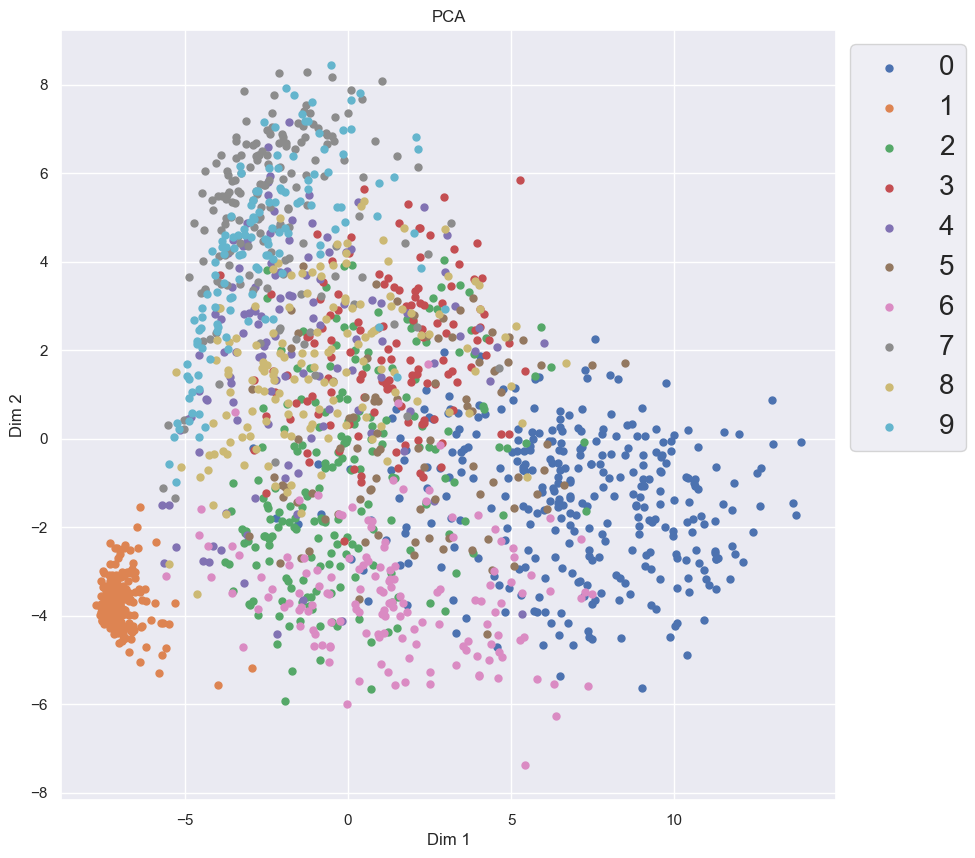

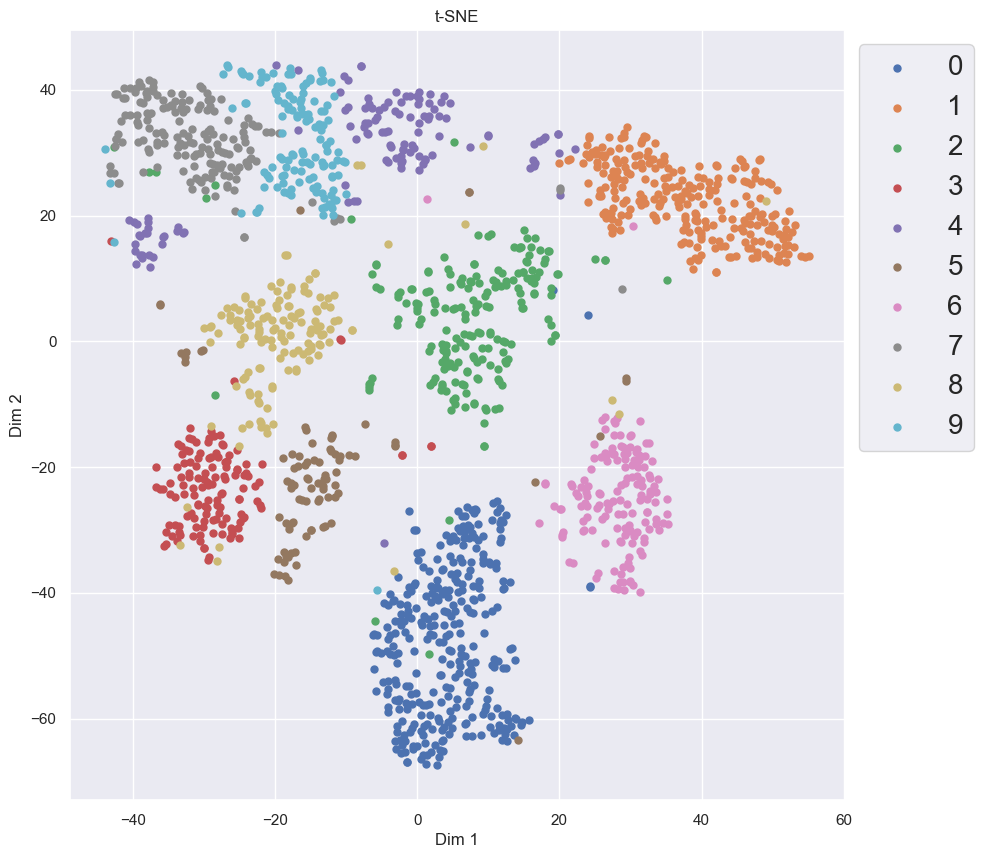

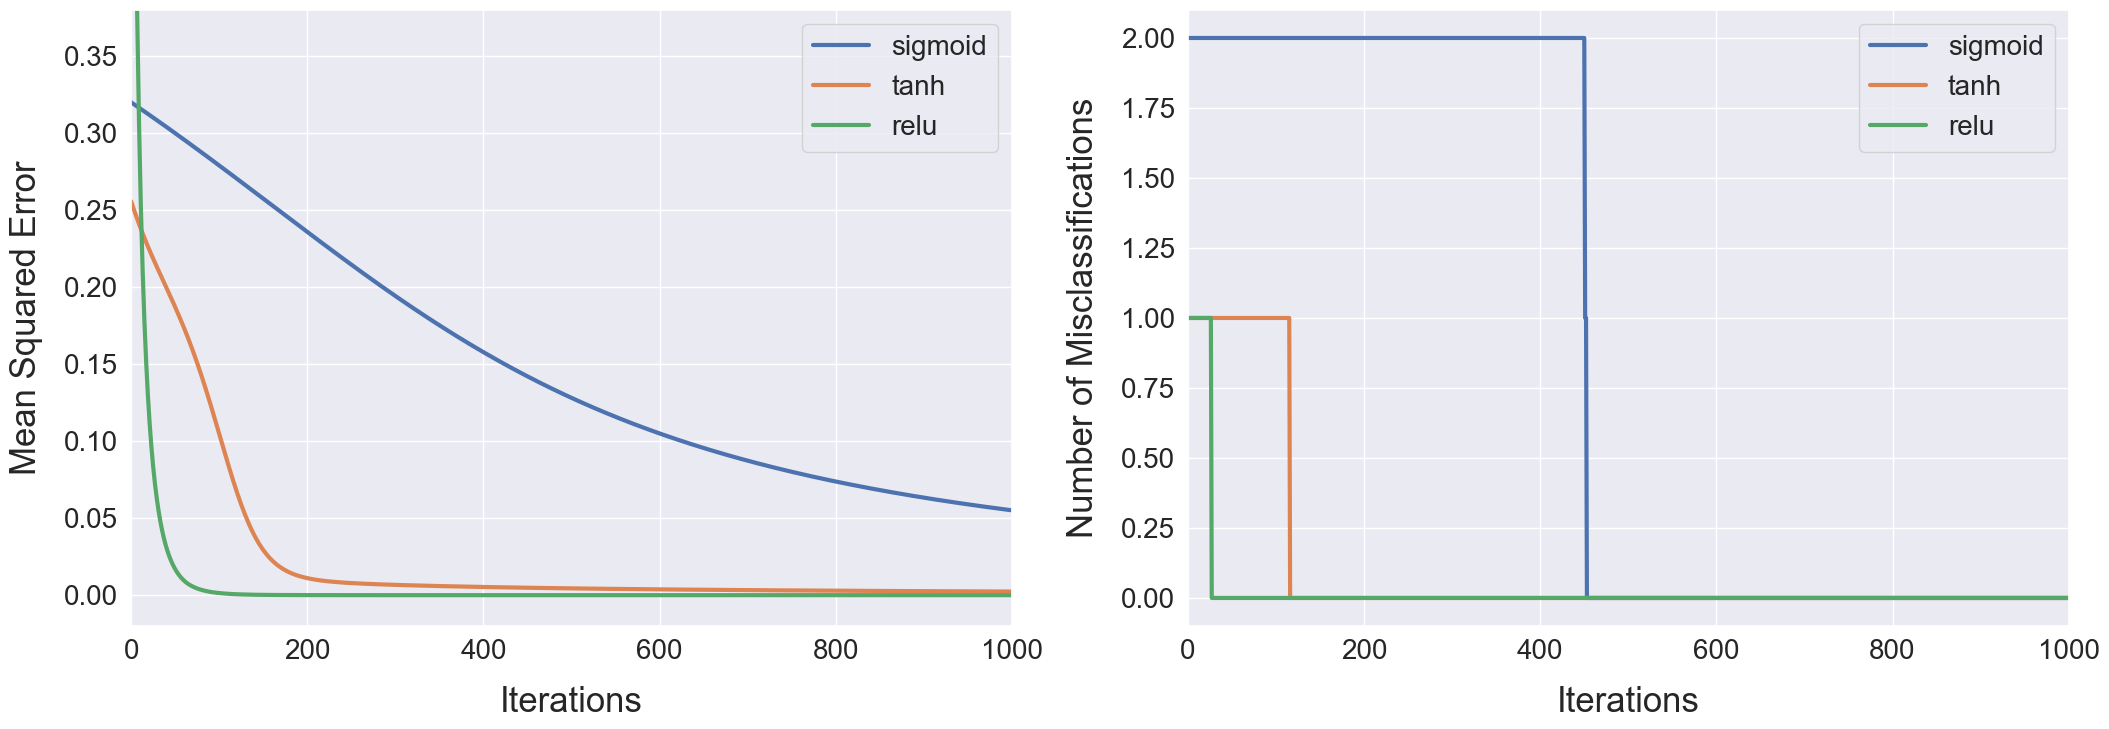

In [51]:
main()